In [1]:
import sys, os, time
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['FOUNDATION_RUN_MODE'] = 'jupyter'
os.environ['FOUNDATION_SAVE_DIR'] = '/is/ei/fleeb/workspace/chome/trained_nets'
os.environ['FOUNDATION_DATA_DIR'] = '/is/ei/fleeb/workspace/local_data'
# %load_ext autoreload
# %autoreload 2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim as O
import torch.distributions as distrib
import torch.multiprocessing as mp
import torchvision.models
import torchvision
from torch.utils.data import Dataset, DataLoader
import gym
from io import BytesIO
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import inspect
import numpy as np
import h5py as hf
%matplotlib notebook
# %matplotlib tk
import matplotlib.pyplot as plt
import seaborn as sns
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import foundation as fd
from foundation import models
from foundation import util
from foundation import train
from foundation import sim as SIM
#from foundation.util import replicate, Cloner
from scipy import stats
np.set_printoptions(linewidth=120)

In [131]:
torchvision.datasets.CelebA?

In [2]:
# celeba

dataset = torchvision.datasets.CelebA(os.path.join(os.environ['FOUNDATION_DATA_DIR']), download=False, 
#                                       transform=torchvision.transforms.ToTensor(), 
                                      transform=None, target_type='identity',
                                      split='all')
len(dataset)

202599

In [3]:
x, y = dataset[0]
type(x)

PIL.JpegImagePlugin.JpegImageFile

In [4]:
img = np.array(x)
img.shape, img.dtype

((218, 178, 3), dtype('uint8'))

In [5]:
y

tensor(2880)

In [6]:
s = util.rgb_to_str(img)
len(s)

78991

In [7]:
type(s)

bytes

In [8]:
np.product(img.shape) * 202599 // 1e6

23584.0

In [5]:
full_path = os.path.join(os.environ['FOUNDATION_DATA_DIR'], 'celeba', 'celeba_train.h5')
full_path

'/is/ei/fleeb/workspace/local_data/celeba/celeba_train.h5'

In [175]:
# with hf.File(full_path, 'w') as f:
#     f.attrs['attr_names'] = [a.encode('ascii', 'replace') for a in attrs]
#     f.create_dataset('images', data=[s, s])

In [176]:
# f = hf.File(full_path, 'r')
# list(f.keys())

In [177]:
# f['images'].shape

In [178]:
# list(f.attrs)

In [179]:
# aload = f.attrs['attr_names']
# sload = f['images'][()]

In [180]:
# f.close()

In [181]:
# aload

In [121]:
# idents
with open(os.path.join(os.environ['FOUNDATION_DATA_DIR'], 'celeba', 'identity_CelebA.txt'), 'r') as f:
    lines = f.readlines()
idents = np.array([int(l.split()[1]) for l in lines])
idents = idents.astype(np.int16)
idents.shape, idents.dtype, sys.getsizeof(idents)

((202599,), dtype('int16'), 405294)

In [122]:
# eval portion
train, test = [], []
with open(os.path.join(os.environ['FOUNDATION_DATA_DIR'], 'celeba', 'list_eval_partition.txt'), 'r') as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        _, cat = line.split()
        if cat == '0':
            train.append(i)
        else:
            test.append(i)
train = np.array(train).astype(np.int32)
test = np.array(test).astype(np.int32)
total = len(train) + len(test)
len(train)/total, len(test)/total, total

(0.8034096910646153, 0.19659030893538468, 202599)

In [123]:
# landmarks
with open(os.path.join(os.environ['FOUNDATION_DATA_DIR'], 'celeba', 'list_landmarks_align_celeba.txt'), 'r') as f:
    lines = f.readlines()
    lmark_names = lines[1].split()
    lines = lines[2:]
lmarks = np.stack([np.array(l.split()[1:]).astype(np.uint8) for l in lines])
# lmarks = lmarks.astype(np.uint8)
lmarks.shape, lmarks.dtype, sys.getsizeof(lmarks), len(lmark_names)

((202599, 10), dtype('uint8'), 2026102, 10)

In [124]:
# attrs
with open(os.path.join(os.environ['FOUNDATION_DATA_DIR'], 'celeba', 'list_attr_celeba.txt'), 'r') as f:
    lines = f.readlines()
    attr_names = lines[1].split()
    lines = lines[2:]
attrs = np.stack([np.array(l.split()[1:]).astype(np.int8) for l in lines])
attrs += 1
attrs //= 2
attrs = attrs.astype(np.uint8)
attrs.shape, attrs.dtype, sys.getsizeof(attrs), len(attr_names)

((202599, 40), dtype('uint8'), 8104072, 40)

In [7]:
img_root = os.path.join(os.environ['FOUNDATION_DATA_DIR'], 'old', 'celeba', 'img_align_celeba',)
img_names = list(sorted(os.listdir(img_root)))
img_names[:10]

['000001.jpg',
 '000002.jpg',
 '000003.jpg',
 '000004.jpg',
 '000005.jpg',
 '000006.jpg',
 '000007.jpg',
 '000008.jpg',
 '000009.jpg',
 '000010.jpg']

In [126]:
def convert(i, iname):
    return i, util.jpeg_to_str(os.path.join(img_root, iname))

In [127]:
all_s = [None]*len(img_names)
farmer = util.Farmer(convert, volatile_gen=({'iname':n, 'i':i} for i,n in enumerate(img_names)), num_workers=8)
for i,s in tqdm(farmer, total=len(dataset)):
    all_s[i] = s
len(all_s)

202599

In [128]:
for s in all_s:
    if s is None:
        print('failed')

In [129]:
train_path = os.path.join(os.environ['FOUNDATION_DATA_DIR'], 'celeba', 'celeba_train.h5')
train_path

'/is/ei/fleeb/workspace/local_data/celeba/celeba_train.h5'

In [130]:
with hf.File(train_path, 'w') as f:
    f.attrs['attr_names'] = [a.encode('ascii', 'replace') for a in attr_names]
    f.attrs['landmark_names'] = [a.encode('ascii', 'replace') for a in lmark_names]
    f.attrs['image_encoding'] = 'jpg'
#     f.create_dataset('eval_idx', data=test)
    f.create_dataset('attrs', data=attrs[:len(train)])
    f.create_dataset('landmarks', data=lmarks[:len(train)])
    f.create_dataset('identities', data=idents[:len(train)])
    f.create_dataset('images', data=all_s[:len(train)])

In [131]:
test_path = os.path.join(os.environ['FOUNDATION_DATA_DIR'], 'celeba', 'celeba_test.h5')
test_path

'/is/ei/fleeb/workspace/local_data/celeba/celeba_test.h5'

In [132]:
with hf.File(test_path, 'w') as f:
    f.attrs['attr_names'] = [a.encode('ascii', 'replace') for a in attr_names]
    f.attrs['landmark_names'] = [a.encode('ascii', 'replace') for a in lmark_names]
    f.attrs['image_encoding'] = 'jpg'
#     f.create_dataset('eval_idx', data=test)
    f.create_dataset('attrs', data=attrs[len(train):])
    f.create_dataset('landmarks', data=lmarks[len(train):])
    f.create_dataset('identities', data=idents[len(train):])
    f.create_dataset('images', data=all_s[len(train):])

In [8]:
imgroot = os.path.join(os.environ['FOUNDATION_DATA_DIR'], 'old', 'celeba', 'img_align_celeba')
img_names = list(sorted(os.listdir(imgroot)))
imgfmt = '{}.jpg'

In [10]:
i = np.random.randint(len(img_names))
imgfmt.format('{}'.format(i+1).zfill(6))

'002987.jpg'

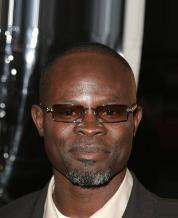

In [11]:
lpath = os.path.join(imgroot, imgfmt.format('{}'.format(i+1).zfill(6)))
limg = Image.open(lpath)
z = np.array(limg)
limg

In [12]:
if i < len(train):
    with hf.File(os.path.join(os.environ['FOUNDATION_DATA_DIR'], 'celeba', 'celeba_train.h5'), 'r') as f:
        img = util.str_to_jpeg(f['images'][i], ret_PIL=True)
        x = np.array(img)
        attrs = f['attrs'][i]
        anames = f.attrs['attr_names']
else:
    with hf.File(os.path.join(os.environ['FOUNDATION_DATA_DIR'], 'celeba', 'celeba_test.h5'), 'r') as f:
        img = util.str_to_jpeg(f['images'][i-len(train)], ret_PIL=True)
        x = np.array(img)
        attrs = f['attrs'][i-len(train)]
        anames = f.attrs['attr_names']
img

TypeError: object of type 'module' has no len()

In [169]:
anames = [n.decode() for n in anames]
for atr, name in zip(attrs, anames):
    if atr:
        print(name)

Attractive
Bangs
Heavy_Makeup
No_Beard
Pointy_Nose
Smiling
Wearing_Lipstick
Wearing_Necklace
Young


In [300]:
# lpath = os.path.join(os.environ['FOUNDATION_DATA_DIR'], 'celeba', 'img_align_celeba', '000001.jpg')
# limg = Image.open(open(lpath, 'rb'))
# with open(lpath, 'rb') as f:
#     lbts = f.read()
# len(lbts)

11440

In [28]:
s = all_s[0]
len(s)

11440

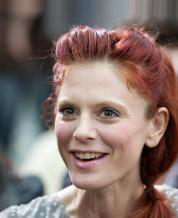

In [30]:
util.str_to_jpeg(all_s[1], ret_PIL=True)

In [294]:
buffer = BytesIO()
x.save(buffer, "JPEG", quality=100)

In [295]:
bts = buffer.getvalue()
len(bts)

32034

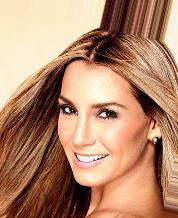

In [296]:
x

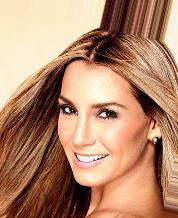

In [304]:
z = np.array(Image.open(BytesIO(lbts)))
reca = np.array(z)
z

In [177]:
list(map(len,all_s[:10]))

[11440, 7448, 4253, 10747, 6351, 8073, 8203, 7725, 8641, 7003]

In [303]:
root = os.path.join(os.environ['FOUNDATION_DATA_DIR'], 'celeba', 'img_align_celeba')
[os.path.getsize(os.path.join(root, x)) for x in sorted(os.listdir(root))[:10]]

[11440, 7448, 4253, 10747, 6351, 8073, 8203, 7725, 8641, 7003]

In [220]:
np.product(img.shape)

116412

In [232]:
len(all_s)

202599

In [176]:
np.product(x.shape)

116412

In [178]:
np.product(x.shape) * len(all_s) / 1e9

23.584954788

In [13]:
with hf.File(os.path.join(os.environ['FOUNDATION_DATA_DIR'], 'celeba', 'celeba_test.h5'), 'r') as f:
    strs = f['images'][()]
    print(list(f.attrs.keys()))
    print(list(f.keys()))
len(strs)

['attr_names', 'image_encoding', 'landmark_names']
['attrs', 'identities', 'images', 'landmarks']


39829

In [ ]:
full = []
for s in tqdm(strs):
    full.append(util.str_to_jpeg(s))
full = np.stack(full)
full.shape

(162770, 218, 178, 3)

In [ ]:
full = torch.from_numpy(full).permute(0,3,1,2)
full.shape, full.dtype

In [ ]:
b = strs[[0,2,3]]
b.shape

In [27]:
dataset = train.get_dataset('celeba', dataroot=os.environ['FOUNDATION_DATA_DIR'], label_type='attr', resize=False)

In [28]:
len(dataset)

162770

In [69]:
i = np.random.randint(len(dataset))

In [70]:
x, y = dataset[i]
x.shape, y.shape

(torch.Size([3, 218, 178]), torch.Size([40]))

<IPython.core.display.Javascript object>


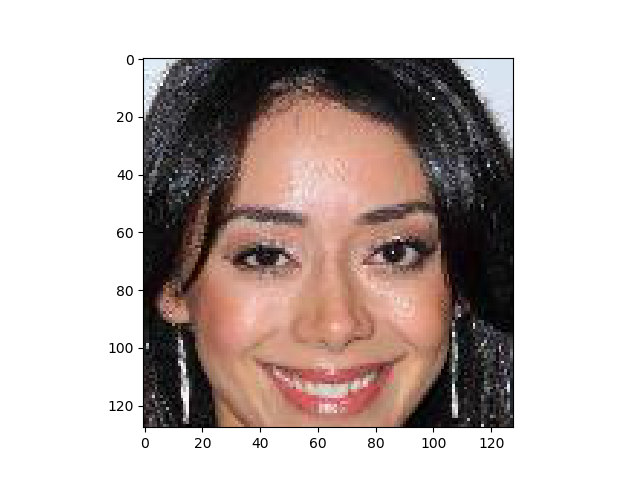

In [71]:
plt.imshow(x.permute(1,2,0).numpy())

In [72]:
_,h,w = x.shape
cy, cx = h//2, w//2
cy, cx

(109, 89)

In [73]:
size = 128

In [74]:
rx = x[:,cy-size//2:cy+size//2, cx-size//2:cx+size//2]
plt.imshow(rx.permute(1,2,0).numpy())
rx.shape

torch.Size([3, 128, 128])